In [1]:
#!/usr/bin/python
import cv2
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
DES_FILE = "demo_kpt_des" # directory name
IMAGE_FILE = 'image.jpg' # image file
VIDEO_FILE = 'demo.mp4' # video file
SKIP_INTERVAL = 5 #intervals between the carrot and the donkey

# Create an ORB object and detect keypoints and descriptors in the template
orb = cv2.ORB_create()
# Create a brute-force matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [3]:
def keypoints_from_image_file(image_file):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect keypoints and compute descriptors in the frame
    keypoints, des = orb.detectAndCompute(gray, None)
    return keypoints, des, img

In [4]:
def load_descriptors(file_name):
    fs = cv2.FileStorage(file_name, cv2.FILE_STORAGE_READ)
    descriptors = fs.getNode("descriptors").mat()
    keypoints = fs.getNode("keypoints").mat()
    fs.release()
    return keypoints, descriptors

In [5]:
def convert_keypoints(keypoints):
    points = []
    for i in range(len(keypoints)):
        (x, y) = img_keypoints[i].pt
        points.append(np.array((x, y)))
    points = np.array(points)
    return points

In [6]:
def find_best_interval(img_descriptors, img):
    ave_sum_distances = []
    best_interval = -1
    best_sq_dist = math.inf
    # Iterate through all intervals to find the interval that matches the most with the image descriptors
    for i in range(len([entry for entry in os.listdir(DES_FILE)])):
        # load the descriptor for the interval
        keypoints, descriptors = load_descriptors(DES_FILE + "/" + DES_FILE + str(i+1) + ".yml")
        # match the descriptors with the image
        matches = bf.match(img_descriptors, descriptors)
        # print(len(matches))
        # cummulate the average hamming distance for each interval match
        ave_sum_distance = sum([m.distance for m in matches]) / len(matches)
        ave_sum_distances.append(ave_sum_distance)
        # find the best match with the least distance
        if ave_sum_distance <= best_sq_dist:
            best_sq_dist = ave_sum_distance
            best_interval = i
    return best_interval

In [7]:
def keypoint_coordinate(matches, query_keypoints, train_keypoints):
    query_xy, train_xy = [], []
    for match in matches:
        query_idx = match.queryIdx
        (x1, y1) = query_keypoints[query_idx]
        query_xy.append(np.array((x1, y1)))
        train_idx = match.trainIdx
        (x2, y2) = train_keypoints[train_idx]
        train_xy.append(np.array((x2, y2)))
    return query_xy, train_xy

In [8]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Obtain the eigenvalues of this 2D dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    # Calculating the standard deviation of x 
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    # calculating the standard deviation of y 
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    # plot the center of the ellipse
    ax.plot(mean_x, mean_y, 'r.')
    transf = transforms.Affine2D() \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
    return(mean_x, mean_y, ell_radius_x, ell_radius_y)

In [9]:
def plot_pair_analysis(query, query_name, train, train_name, h, w):
    #Keypoints of the obtained image
    qx = np.array([x for (x, y) in query])
    qy = np.array([y for (x, y) in query])
    plt.subplot(1, 2, 1) # row 1, col 2 index 1
    plt.plot(qx, qy, '.')
    plt.xlim([0, w])
    plt.ylim([0, h])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    q_mx, q_my, q_rx, q_ry = confidence_ellipse(qx, qy, ax, edgecolor='red')
    plt.title(query_name + " Image Kpts")
    #Keypoints of the reference image
    tx = np.array([x for (x, y) in train])
    ty = np.array([y for (x, y) in train])
    plt.subplot(1, 2, 2) # row 1, col 2 index 2
    plt.plot(tx, ty, '.')
    plt.xlim([0, w])
    plt.ylim([0, h])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    t_mx, t_my, t_rx, t_ry = confidence_ellipse(tx, ty, ax, edgecolor='red')
    plt.title(train_name + " Image Kpts")
    plt.show()
    print("cx deviation:", (q_mx-t_mx)/w) #"how much away"
    print("x distribution ratio:", (q_rx/t_rx)) #"how close"

Best matching interval: 36
Keypoint matches: 29


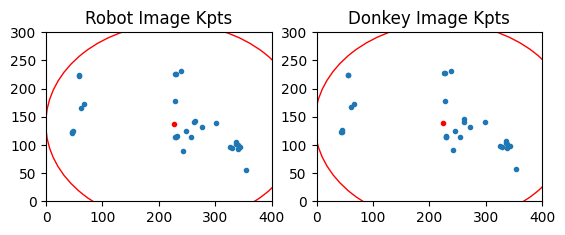

cx deviation: 0.004799023989973392
x distribution ratio: 0.9970278073336223


Keypoint matches: 29


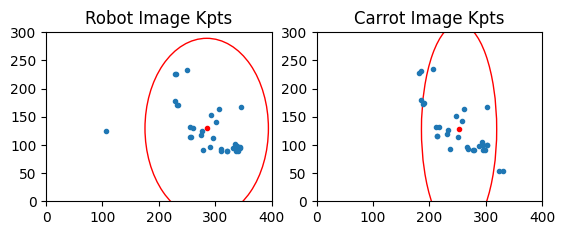

cx deviation: 0.0805813881658738
x distribution ratio: 1.419853046835402


Keypoint matches: 12


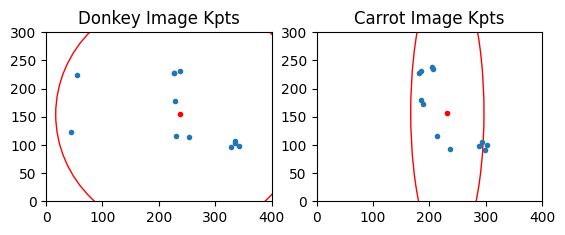

cx deviation: 0.012891089121500698
x distribution ratio: 1.6709423578379596


In [10]:
if __name__ == '__main__':
    # Load retrived image keypoints
    img_keypoints, img_descriptors, img = keypoints_from_image_file(IMAGE_FILE)
    robot_keypoints = convert_keypoints(img_keypoints)
    robot_descriptors = img_descriptors
    # Find the best matching interval reference
    interval = find_best_interval(robot_descriptors, img)
    # Load reference image keypoints
    ref_keypoints, ref_descriptors = load_descriptors(DES_FILE + "/" + DES_FILE + str(interval+1) + ".yml")
    
    # Match the descriptors of robot and donkey
    matches1 = bf.match(robot_descriptors, ref_descriptors)
    print("Best matching interval: " + str(interval+1))
    print("Keypoint matches: " + str(len(matches1)))
    # Find matching keypoints coordinates for retrived and reference keypoints
    robot_xy, donkey_xy = keypoint_coordinate(matches1, robot_keypoints, ref_keypoints)
    # Plot the keypoints analysis
    plot_pair_analysis(robot_xy, "Robot", donkey_xy, "Donkey", img.shape[0], img.shape[1])
    
    # Load reference image keypoints
    goal_keypoints, goal_descriptors = load_descriptors(DES_FILE + "/" + DES_FILE + str((interval+1)+SKIP_INTERVAL) + ".yml")
    
    # Match the descriptors of robot and carror
    matches2 = bf.match(robot_descriptors, goal_descriptors)
    print("\n\nKeypoint matches: " + str(len(matches1)))
    # Find matching keypoints coordinates for retrived and reference keypoints
    robot_xy, carrot_xy = keypoint_coordinate(matches2, robot_keypoints, goal_keypoints)
    # Plot the keypoints analysis
    plot_pair_analysis(robot_xy, "Robot", carrot_xy, "Carrot", img.shape[0], img.shape[1])

    # Match the descriptors of donkey and carrot
    matches3 = bf.match(ref_descriptors, goal_descriptors)
    print("\n\nKeypoint matches: " + str(len(matches3)))
    # Find matching keypoints coordinates for retrived and reference keypoints
    donkey_xy, carrot_xy = keypoint_coordinate(matches3, ref_keypoints, goal_keypoints)
    # Plot the keypoints analysis
    plot_pair_analysis(donkey_xy, "Donkey", carrot_xy, "Carrot", img.shape[0], img.shape[1])
    